In [1]:
from utils import load_cnf, cnf_to_bqm
from embedding_utils import *
import seaborn as sns
from redundancy import *
from utils import *

In [2]:
folder = 'sat'
_variables = 160
path = f"./{folder}/sgen1-{folder}-{_variables}-100.cnf"

In [3]:
num_variables, num_clauses, variables, clauses = load_cnf(path)
bqm, or_result_vars, clauses_qubits, _ = cnf_to_bqm(variables, clauses)

In [4]:
len(bqm.adj)

160

In [616]:
num_variables

160

In [437]:
cnf_result = "-1 -2 3 -4 -5 6 -7 -8 -9 -10 -11 12 -13 -14 -15 -16 -17 18 -19 -20 -21 -22 23 -24 -25 -26 27 -28 -29 -30 -31 32 -33 -34 -35 36 -37 -38 -39 -40 41 -42 -43 -44 -45 -46 -47 -48 49 -50 51 -52 -53 -54 -55 -56 -57 -58 59 -60 61 -62 -63 -64 -65 -66 -67 68 -69 -70 71 -72 -73 -74 -75 -76 -77 78 -79 -80 -81 -82 -83 84 -85 -86 87 -88 -89 -90 -91 -92 -93 94 -95 -96 -97 -98 99 -100 -101 -102 -103 104 -105 -106 107 -108 -109 -110 -111 -112 113 -114 -115 116 -117 -118 -119 -120 -121 -122 -123 124 -125 -126 -127 128 -129 -130 -131 -132 133 -134 -135 136 -137 -138 -139 -140 -141 -142 -143 144 -145 -146 -147 -148 149 -150 -151 152 -153 -154 -155 -156 -157 -158 159 -160 0".split(" ")
answer = dict()
for x in cnf_result[:-1]:
    int_x = int(x)
    answer[abs(int_x)] = int(int_x > 0)
evaluate_cnf_formula(answer, or_result_vars, bqm)

0.0

In [73]:
answer_all_values = get_qubits_values(answer, or_result_vars, bqm)

# Minor Embedding

1415


<AxesSubplot:ylabel='Count'>

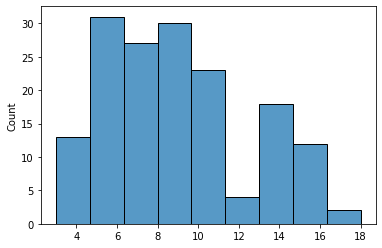

In [6]:
embedding = get_embedding(bqm, 109)
print(count_qubits_used(embedding))
sns.histplot(get_chain_lengths(bqm, embedding)[0])

In [627]:
for clause in clauses:
    line = ""
    true_bits = 0
    for var in clause:
        line += f" {answer[abs(var)]}"
        if answer[abs(var)] == 1:
            true_bits +=1
    if len(clause) == 5:
        assert(true_bits == 1)

# QPU

In [7]:
sampler =  get_greedy_quantum_sampler(embedding)

### Standard setup

In [9]:
sampleset_standard = sampler.sample(bqm, num_reads=1000, answer_mode='raw', chain_strength=1.5, auto_scale=True)
print(sampleset_standard.first.energy)
get_avg_energy(sampleset_standard)

12.0


21.42

In [10]:
sampleset_standard = sampler.sample(bqm, num_reads=100, answer_mode='raw', chain_strength=1.75, auto_scale=True)
print(sampleset_standard.first.energy)
get_avg_energy(sampleset_standard)

12.0


21.52

In [15]:
bqm.scale(0.5)

In [20]:
sampleset_standard = sampler.sample(bqm, num_reads=1000, answer_mode='raw', chain_strength=2, auto_scale=True)
print(sampleset_standard.first.energy)
get_avg_energy(sampleset_standard)

RequestTimeout: API request timed out

### with annealing offsets

In [ ]:
qubit_offsets = get_0_qubits_offsets()
qpu_offsets = get_qubit_offset_ranges()
advance_annealing_of_unused(embedding, qubit_offsets)

In [53]:
# def get_offset(qpu_offsets, c):
#     min_offset = get_min_offset(qpu_offsets, c)
#     return min_offset
#set_logic_var_annealing_offsets(embedding, qubit_offsets, num_variables, get_offset)
qpu_offsets = get_qubit_offset_ranges()
for (logic_var, chain) in embedding.items():
    for c in chain:
        min_offset = get_min_offset(qpu_offsets, c)
        if logic_var <= num_variables:
            qubit_offsets[c] = min_offset
        else:
            divisor = 14-len(chain)+1
            qubit_offsets[c] = min_offset/divisor

In [54]:
sampleset_offsets = sampler.sample(bqm, num_reads=100, answer_mode='raw', anneal_offsets=qubit_offsets, chain_strength=1.25, auto_scale=True)
print(sampleset_offsets.first.energy)
print(get_avg_energy(sampleset_offsets))

14.0
17.28


In [55]:
sampleset_offsets = sampler.sample(bqm, num_reads=100, anneal_schedule=[[0.0,0.0],[10.0,0.9],[12.0,1.0]],answer_mode='raw', anneal_offsets=qubit_offsets, chain_strength=1.25, auto_scale=True)
print(sampleset_offsets.first.energy)
print(get_avg_energy(sampleset_offsets))

14.0
16.9


In [599]:
sampleset_offsets = sampler.sample(bqm, num_reads=100, 
                                   anneal_schedule=[[0.0,1.0],[10, 0.45],[20.0,1.0]],
                                   answer_mode='raw', 
                                   anneal_offsets=qubit_offsets, 
                                   chain_strength=1.25, 
                                   auto_scale=True, initial_state=temp, 
                                   reinitialize_state=True)
print(sampleset_offsets.first.energy)
print(get_avg_energy(sampleset_offsets))

1.0
2.0


In [527]:
get_distance(answer,sampleset_offsets.first.sample)

36

In [119]:
len(sampleset_offsets.lowest())

72

In [125]:
def get_hamming_distance(answer, sample):
    distance = 0
    for (key, value) in answer.items():
        print(key, value, sample[key])
        distance += int(value != sample[key])
    return distance

In [126]:
for sample in sampleset_offsets.lowest():
    print(get_hamming_distance(answer, sample))

1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
22 0 0
23 1 1
24 0 0
25 0 0
26 0 0
27 1 1
28 0 0
29 0 0
30 0 0
31 0 0
32 1 1
33 0 0
34 0 0
35 0 0
36 1 1
37 0 0
38 0 0
39 0 0
40 0 0
41 1 1
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 1 1
50 0 0
51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 1 1
60 0 0
61 1 1
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 1 1
69 0 0
70 0 0
71 1 1
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 1 1
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 1 1
95 0 0
96 0 0
97 0 0
98 0 0
99 1 1
100 0 0
101 0 0
102 0 0
103 0 0
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 1 1
125 0 0
126 0 0
127 0 0
128 1 1
129 0 0
130 0 0
131 0 0
132 0 0
133 1 1
134 0 0
135 0 0
136 1 1
137 0 0
138 0 0
139 

83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 1 1
95 0 0
96 0 0
97 0 0
98 0 0
99 1 1
100 0 0
101 0 0
102 0 0
103 0 0
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 1 1
125 0 0
126 0 0
127 0 0
128 1 1
129 0 0
130 0 0
131 0 0
132 0 0
133 1 1
134 0 0
135 0 0
136 1 1
137 0 0
138 0 0
139 0 0
140 0 0
141 0 0
142 0 0
143 0 0
144 1 1
145 0 0
146 0 0
147 0 0
148 0 0
149 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 0 0
155 0 0
156 0 0
157 0 0
158 0 0
159 1 1
160 0 0
0
1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
22 0 0
23 1 1
24 0 0
25 0 0
26 0 0
27 1 1
28 0 0
29 0 0
30 0 0
31 0 0
32 1 1
33 0 0
34 0 0
35 0 0
36 1 1
37 0 0
38 0 0
39 0 0
40 0 0
41 1 1
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 1 1
50 0 0
51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
5

146 0 0
147 0 0
148 0 0
149 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 0 0
155 0 0
156 0 0
157 0 0
158 0 0
159 1 1
160 0 0
0
1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
22 0 0
23 1 1
24 0 0
25 0 0
26 0 0
27 1 1
28 0 0
29 0 0
30 0 0
31 0 0
32 1 1
33 0 0
34 0 0
35 0 0
36 1 1
37 0 0
38 0 0
39 0 0
40 0 0
41 1 1
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 1 1
50 0 0
51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 1 1
60 0 0
61 1 1
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 1 1
69 0 0
70 0 0
71 1 1
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 1 1
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 1 1
95 0 0
96 0 0
97 0 0
98 0 0
99 1 1
100 0 0
101 0 0
102 0 0
103 0 0
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
12

49 1 1
50 0 0
51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 1 1
60 0 0
61 1 1
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 1 1
69 0 0
70 0 0
71 1 1
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 1 1
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 1 1
95 0 0
96 0 0
97 0 0
98 0 0
99 1 1
100 0 0
101 0 0
102 0 0
103 0 0
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 1 1
125 0 0
126 0 0
127 0 0
128 1 1
129 0 0
130 0 0
131 0 0
132 0 0
133 1 1
134 0 0
135 0 0
136 1 1
137 0 0
138 0 0
139 0 0
140 0 0
141 0 0
142 0 0
143 0 0
144 1 1
145 0 0
146 0 0
147 0 0
148 0 0
149 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 0 0
155 0 0
156 0 0
157 0 0
158 0 0
159 1 1
160 0 0
0
1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
22 0 0
23 1 1
2

112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 1 1
125 0 0
126 0 0
127 0 0
128 1 1
129 0 0
130 0 0
131 0 0
132 0 0
133 1 1
134 0 0
135 0 0
136 1 1
137 0 0
138 0 0
139 0 0
140 0 0
141 0 0
142 0 0
143 0 0
144 1 1
145 0 0
146 0 0
147 0 0
148 0 0
149 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 0 0
155 0 0
156 0 0
157 0 0
158 0 0
159 1 1
160 0 0
0
1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
22 0 0
23 1 1
24 0 0
25 0 0
26 0 0
27 1 1
28 0 0
29 0 0
30 0 0
31 0 0
32 1 1
33 0 0
34 0 0
35 0 0
36 1 1
37 0 0
38 0 0
39 0 0
40 0 0
41 1 1
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 1 1
50 0 0
51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 1 1
60 0 0
61 1 1
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 1 1
69 0 0
70 0 0
71 1 1
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 1 1
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0

47 0 0
48 0 0
49 1 1
50 0 0
51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 1 1
60 0 0
61 1 1
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 1 1
69 0 0
70 0 0
71 1 1
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 1 1
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 1 1
95 0 0
96 0 0
97 0 0
98 0 0
99 1 1
100 0 0
101 0 0
102 0 0
103 0 0
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 1 1
125 0 0
126 0 0
127 0 0
128 1 1
129 0 0
130 0 0
131 0 0
132 0 0
133 1 1
134 0 0
135 0 0
136 1 1
137 0 0
138 0 0
139 0 0
140 0 0
141 0 0
142 0 0
143 0 0
144 1 1
145 0 0
146 0 0
147 0 0
148 0 0
149 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 0 0
155 0 0
156 0 0
157 0 0
158 0 0
159 1 1
160 0 0
0
1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
2

51 1 1
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 1 1
60 0 0
61 1 1
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 1 1
69 0 0
70 0 0
71 1 1
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 1 1
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 1 1
85 0 0
86 0 0
87 1 1
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 1 1
95 0 0
96 0 0
97 0 0
98 0 0
99 1 1
100 0 0
101 0 0
102 0 0
103 0 0
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 1 1
114 0 0
115 0 0
116 1 1
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 1 1
125 0 0
126 0 0
127 0 0
128 1 1
129 0 0
130 0 0
131 0 0
132 0 0
133 1 1
134 0 0
135 0 0
136 1 1
137 0 0
138 0 0
139 0 0
140 0 0
141 0 0
142 0 0
143 0 0
144 1 1
145 0 0
146 0 0
147 0 0
148 0 0
149 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 0 0
155 0 0
156 0 0
157 0 0
158 0 0
159 1 1
160 0 0
0
1 0 0
2 0 0
3 1 1
4 0 0
5 0 0
6 1 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 1 1
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 1
19 0 0
20 0 0
21 0 0
22 0 0
23 1 1
24 0 0
25 0 0
2

------

In [444]:
import random
import copy

def find_combinations(current_state, distance, current_index, max_samples, combinations):
    if current_index > 161:
        return 0
    if len(combinations) == max_samples:
        return 0
    if distance > len(current_state.keys()) - current_index +1:
        return 0
    if distance == 0:
        current_state_energy = evaluate_cnf_formula(current_state, or_result_vars, bqm)
        if current_state_energy > 0:
            combinations.append(copy.deepcopy(current_state))
            return 0
        assert(current_state_energy == 0)
        return 1
    elif current_index > len(current_state.keys()):
        return 0
    else:
        # try flipping current_index
        current_state[current_index] = (current_state[current_index] + 1) % 2
        ans = find_combinations(current_state, distance-1, current_index+1, max_samples, combinations)
        
        current_state[current_index] = (current_state[current_index] + 1) % 2
        ans += find_combinations(current_state, distance, current_index+1, max_samples, combinations)
        return ans
    
    
def flip_bits(ground_state, distance, max_samples=10000):
    combinations = []
    count_ground_states = find_combinations(ground_state, distance, 1, max_samples, combinations)
    return combinations, count_ground_states
    
    

In [478]:
combinations, count_ground_states = flip_bits(answer_all_values,1)
print(len(combinations))
print(count_ground_states)

160
0


In [479]:
bqm.energy(combinations[0])

1.0

In [324]:
for i in range(len(qubit_offsets)):
    if i > 161:
        qubit_offsets[i]
    qubit_offsets[i]/=10

In [344]:
def flip_bits(sample, num_bits, seed=1):
    random.seed(seed)
    for i in range(num_bits):
        random_num = random.randint(1, 161)
        sample[random_num] = (sample[random_num]+1) % 2
    return sample
    

In [610]:
sampleset_h1 = sampler.sample(bqm, num_reads=100, 
                                   anneal_schedule=[[0.0, 1.0],[2.5,0.6],[13.5,0.6] ,[15, 1.0]],
                                   answer_mode='raw', 
                                   chain_strength=1.5,
                                   anneal_offsets=qubit_offsets,
                                   auto_scale=True, initial_state=sampleset_h1.first.sample, 
                                   reinitialize_state=True)
print(sampleset_h1.first.energy)
print(get_avg_energy(sampleset_h1))

2.0
2.0


In [605]:
len(sampleset_h1)

100

In [607]:
temp = None
i = 0
for sample in sampleset_h1:
    if i == len(sampleset_h1)-1:
        temp = sample
    i+=1
bqm.energy(temp)

6.0

In [ ]:
sampleset

In [466]:
bqm.energy(combinations[0])

0.0

In [269]:
len(sampleset_h1.lowest())

100

In [279]:
prev_lowest_samples = sampleset_h1.lowest()

In [480]:
prev_lowest_samples.first.energy

1.0

In [278]:
def extract_input_bits_from_sample(sample):
    answer = dict()
    for i in range(1, 161):
        answer[i] = sample[i]
    return answer

In [ ]:
# check that output gates are OK
for sample in prev_lowest_samples.lowest():
    input_bits = extract_input_bits_from_sample(sample)
    for i in range(1, 161):
        for j in range(i+1, 161):
            input_bits[i] = (input_bits[i]+1) % 2
            input_bits[j] = (input_bits[j]+1) % 2
            energy = evaluate_cnf_formula(input_bits,or_result_vars, bqm )
            if  energy < 1:
                print(f"energy {energy}")
            input_bits[i] = (input_bits[i]+1) % 2
            input_bits[j] = (input_bits[j]+1) % 2

In [294]:
def get_distance(sample1, sample2):
    distance = 0
    for (key, value) in sample1.items():
        if value != sample2[key]:
            distance+=1
    return distance

In [301]:
import neal
ss_sampler = neal.SimulatedAnnealingSampler()

ss_sampler.sample(bqm, initial_state=prev_lowest_samples.first.sample).first.energy

9.0

In [402]:
get_distance(answer, combinations[0])

1

In [486]:
for c in combinations:
    print(get_distance(prev_lowest_samples.first.sample, c))

18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
16
18
18
18
18
18
18
18
18
18
18
16
16
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
16
18
18
18
16
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18


In [490]:
for (key, value) in answer.items():
    if prev_lowest_samples.first.sample[key] != value:
        print(key)

21
32
33
136
140


In [620]:
get_false_clauses(temp, clauses)

[[-21, -23], [-87, -89], [-116, -119], [-142, -144]]

In [567]:
temp = copy.deepcopy(prev_lowest_samples.first.sample)

In [589]:
temp[21] = 1
temp[23] = 1

In [590]:
temp[21]

1

In [611]:
get_distance(answer, sampleset_h1.first.sample)

6

In [543]:
temp[136] = 1
temp[32] = 1

In [555]:
target_qubits = []

for c in embedding[21]:
    target_qubits.append(c)
    
for c in embedding[23]:
    target_qubits.append(c)
target_qubits

[1636, 3263, 3233, 3234, 3249, 3247, 3248, 1861, 3384, 1922]

In [602]:
for q in target_qubits:
    qubit_offsets[q] = 0.5

In [619]:
bqm.energy(prev_lowest_samples.first.sample)

1.0

In [621]:
bqm.energy(temp)

6.0